**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean', standartisation=False):
        self.k = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.standartisation = standartisation
    
    def fit(self, X, y):
        # assume X.shape[0] = y.shape[0]
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        if self.standartisation:
            self.X_train = (self.X_train - self.X_train.mean()) / self.X_train.std()
        if self.algorithm == 'kd_tree':
            self.kd_tree = KDTree(self.X_train, metric=self.metric
                                  if self.metric in KDTree.valid_metrics
                                  else 'euclidean')
    
    def predict(self, X):
        if self.algorithm == 'brute':
            dist = pairwise_distances(X, self.X_train, self.metric)
            indices = np.argpartition(dist, self.k)[:,:self.k]
            k_nearest_indices = np.take_along_axis(indices, np.argsort(
                np.take_along_axis(dist, indices, axis=1), axis=1), axis=1)[:, ::-1]
        
        elif self.algorithm == 'kd_tree':
            k_nearest_indices = self.kd_tree.query(X, k=self.k, return_distance=False)
        
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=self.y_train[k_nearest_indices])

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 376 µs, sys: 72 µs, total: 448 µs
Wall time: 456 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 21 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.77 ms, sys: 146 µs, total: 1.91 ms
Wall time: 2.63 ms


array([2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 791 µs, sys: 0 ns, total: 791 µs
Wall time: 1.14 ms


array([2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 593 µs, sys: 114 µs, total: 707 µs
Wall time: 732 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 214 µs, sys: 0 ns, total: 214 µs
Wall time: 227 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 2.57 ms


array([0, 1, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 521 µs, sys: 0 ns, total: 521 µs
Wall time: 674 µs


array([0, 1, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [22]:
vectorizer = CountVectorizer(max_features=1000)
X_data = vectorizer.fit_transform(data)

vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_data_tfidf = vectorizer_tfidf.fit_transform(data)

Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
def get_score_cross_val(X, y, k, algorithm='brute', metric='cosine', n_splits=3, standartisation=True, print_results=False):
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    scores = list()
    i = 1
    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index].toarray(), X[test_index].toarray()
        y_train, y_test = y[train_index], y[test_index]
        
        my_clf = MyKNeighborsClassifier(k, algorithm=algorithm, metric=metric,
                                        standartisation=standartisation)
        my_clf.fit(X_train, y_train)
        prediction = my_clf.predict(X_test)
        score = accuracy_score(y_test, prediction)
        scores.append(score)
        if print_results:
            print('{}: score = {}  '.format(i, score))
        i += 1
    scores = np.array(scores)
    mean = scores.mean()
    if print_results:
        print('Mean = {}  '.format(mean))
    return mean

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [24]:
metrics = ['euclidean', 'cosine']
algorithms = ['brute', 'kd_tree']
scores = list()
scores_spec = list()
best_score = 0.
best_score_spec = None
standartisation = True

plot_points = {
    'euclidean': {
        'brute': {
            'CountVectorizer': [],
            'TfidFVectorizer': []
        },
        'kd_tree': {
            'CountVectorizer': [],
            'TfidFVectorizer': []
        }
    },
    'cosine': {
        'brute': {
            'CountVectorizer': [],
            'TfidFVectorizer': []
        }
    }
}

In [25]:
%%time

print_results = False

for n_neighbours in np.arange(1, 11):
    for algorithm in algorithms:
        for metric in metrics:
            
            if metric == 'cosine' and algorithm == 'kd_tree':
                continue
            
            if print_results:
                print('k = {}; algorithm = {}; metric = {}; standartisation = {}  '.format(
                    n_neighbours, algorithm, metric, standartisation))
            
            # print('1) CountVectorizer  ')
            score = get_score_cross_val(X_data, target, n_neighbours, algorithm, metric, print_results=print_results)
            if score > best_score:
                best_score = score
                best_score_spec = (n_neighbours, algorithm, metric, 'CountVectorizer')
            scores.append(score)
            scores_spec.append((n_neighbours, algorithm, metric, 'CountVectorizer'))
            plot_points[metric][algorithm]['CountVectorizer'].append(score)
            
            if print_results:
                print('\n2) TfidFVectorizer  ')
            score = get_score_cross_val(X_data_tfidf, target, n_neighbours, algorithm, metric, print_results=print_results)
            if score > best_score:
                best_score = score
                best_score_spec = (n_neighbours, algorithm, metric, 'TfidFVectorizer')
            scores.append(score)
            scores_spec.append((n_neighbours, algorithm, metric, 'CountVectorizer'))
            plot_points[metric][algorithm]['TfidFVectorizer'].append(score)
            if print_results:
                print('  ')
                print('*****************************  ')
                print('  ')

print('Best score: {} at k = {}, algorithm = {}, metric = {}, vectorizer = {}  '.format(best_score, *best_score_spec))

Best score: 0.4180672597774368 at k = 10, algorithm = brute, metric = cosine, vectorizer = TfidFVectorizer  
CPU times: user 53min 16s, sys: 15.6 s, total: 53min 31s
Wall time: 50min 13s


Пример вывода при max_features=10, k=1..10

k = 1; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05408271474019088  
2: score = 0.060991779368867675  
3: score = 0.056748872977989924  
Mean = 0.057274455695682826  

2) TfidFVectorizer  
1: score = 0.060445387062566275  
2: score = 0.057014054627419784  
3: score = 0.05197560328825245  
Mean = 0.05647834832607951  
  
*****************************  
  
k = 1; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.08271474019088017  
2: score = 0.08591885441527446  
3: score = 0.09069212410501193  
Mean = 0.08644190623705551  

2) TfidFVectorizer  
1: score = 0.07476139978791092  
2: score = 0.06576504905860514  
3: score = 0.081145584725537  
Mean = 0.07389067785735103  
  
*****************************  
  
k = 1; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05408271474019088  
2: score = 0.060991779368867675  
3: score = 0.056748872977989924  
Mean = 0.057274455695682826  

2) TfidFVectorizer  
1: score = 0.060445387062566275  
2: score = 0.057014054627419784  
3: score = 0.05197560328825245  
Mean = 0.05647834832607951  
  
*****************************  
  
k = 2; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05540827147401909  
2: score = 0.06311323256430655  
3: score = 0.06178732431715725  
Mean = 0.060102942785160964  

2) TfidFVectorizer  
1: score = 0.06495227995758218  
2: score = 0.060461416070007955  
3: score = 0.06311323256430655  
Mean = 0.06284230953063223  
  
*****************************  
  
k = 2; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.08138918345705196  
2: score = 0.08538849111641475  
3: score = 0.09732166534075842  
Mean = 0.08803311330474171  

2) TfidFVectorizer  
1: score = 0.07502651113467657  
2: score = 0.07345531689207106  
3: score = 0.07822858658180853  
Mean = 0.07557013820285206  
  
*****************************  
  
k = 2; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05540827147401909  
2: score = 0.06311323256430655  
3: score = 0.06178732431715725  
Mean = 0.060102942785160964  

2) TfidFVectorizer  
1: score = 0.06495227995758218  
2: score = 0.060461416070007955  
3: score = 0.06311323256430655  
Mean = 0.06284230953063223  
  
*****************************  
  
k = 3; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05275715800636267  
2: score = 0.06417395916202599  
3: score = 0.06417395916202599  
Mean = 0.06036835877680489  

2) TfidFVectorizer  
1: score = 0.06415694591728525  
2: score = 0.059665871121718374  
3: score = 0.05940068947228852  
Mean = 0.06107450217043072  
  
*****************************  
  
k = 3; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.08960763520678686  
2: score = 0.08750994431185362  
3: score = 0.09307875894988067  
Mean = 0.09006544615617372  

2) TfidFVectorizer  
1: score = 0.07184517497348887  
2: score = 0.06629541235746486  
3: score = 0.07159904534606205  
Mean = 0.0699132108923386  
  
*****************************  
  
k = 3; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05275715800636267  
2: score = 0.06417395916202599  
3: score = 0.06417395916202599  
Mean = 0.06036835877680489  

2) TfidFVectorizer  
1: score = 0.06415694591728525  
2: score = 0.059665871121718374  
3: score = 0.05940068947228852  
Mean = 0.06107450217043072  
  
*****************************  
  
k = 4; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05328738069989396  
2: score = 0.0588703261734288  
3: score = 0.06470432246088571  
Mean = 0.05895400977806949  

2) TfidFVectorizer  
1: score = 0.05752916224814422  
2: score = 0.05542296473084063  
3: score = 0.0588703261734288  
Mean = 0.05727415105080455  
  
*****************************  
  
k = 4; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.08536585365853659  
2: score = 0.08485812781755503  
3: score = 0.09626093874303898  
Mean = 0.0888283067397102  

2) TfidFVectorizer  
1: score = 0.07555673382820785  
2: score = 0.07027313709891275  
3: score = 0.06841686555290374  
Mean = 0.07141557882667478  
  
*****************************  
  
k = 4; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05328738069989396  
2: score = 0.0588703261734288  
3: score = 0.06470432246088571  
Mean = 0.05895400977806949  

2) TfidFVectorizer  
1: score = 0.05752916224814422  
2: score = 0.05542296473084063  
3: score = 0.0588703261734288  
Mean = 0.05727415105080455  
  
*****************************  
  
k = 5; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05540827147401909  
2: score = 0.05913550782285866  
3: score = 0.06205250596658711  
Mean = 0.05886542842115496  

2) TfidFVectorizer  
1: score = 0.06362672322375397  
2: score = 0.05489260143198091  
3: score = 0.05250596658711217  
Mean = 0.05700843041428235  
  
*****************************  
  
k = 5; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.08085896076352068  
2: score = 0.08485812781755503  
3: score = 0.08989657915672236  
Mean = 0.08520455591259934  

2) TfidFVectorizer  
1: score = 0.07820784729586426  
2: score = 0.07106868204720233  
3: score = 0.06815168390347388  
Mean = 0.07247607108218017  
  
*****************************  
  
k = 5; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05540827147401909  
2: score = 0.05940068947228852  
3: score = 0.06205250596658711  
Mean = 0.05895382230429824  

2) TfidFVectorizer  
1: score = 0.06362672322375397  
2: score = 0.05489260143198091  
3: score = 0.05250596658711217  
Mean = 0.05700843041428235  
  
*****************************  
  
k = 6; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05726405090137858  
2: score = 0.05833996287456908  
3: score = 0.06311323256430655  
Mean = 0.0595724154467514  

2) TfidFVectorizer  
1: score = 0.06654294803817604  
2: score = 0.057279236276849645  
3: score = 0.05568814638027048  
Mean = 0.05983677689843205  
  
*****************************  
  
k = 6; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.08191940615058324  
2: score = 0.08485812781755503  
3: score = 0.08910103420843278  
Mean = 0.08529285605885702  

2) TfidFVectorizer  
1: score = 0.07820784729586426  
2: score = 0.07106868204720233  
3: score = 0.0713338636966322  
Mean = 0.0735367976798996  
  
*****************************  
  
k = 6; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.05726405090137858  
2: score = 0.05833996287456908  
3: score = 0.06311323256430655  
Mean = 0.0595724154467514  

2) TfidFVectorizer  
1: score = 0.06654294803817604  
2: score = 0.057279236276849645  
3: score = 0.05568814638027048  
Mean = 0.05983677689843205  
  
*****************************  
  
k = 7; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.0612407211028632  
2: score = 0.05595332802970034  
3: score = 0.060726597719437815  
Mean = 0.059306882284000446  

2) TfidFVectorizer  
1: score = 0.06654294803817604  
2: score = 0.059665871121718374  
3: score = 0.057279236276849645  
Mean = 0.06116268514558135  
  
*****************************  
  
k = 7; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.07820784729586426  
2: score = 0.08512330946698489  
3: score = 0.08618403606470432  
Mean = 0.08317173094251783  

2) TfidFVectorizer  
1: score = 0.07714740190880169  
2: score = 0.07319013524264122  
3: score = 0.0745160434897905  
Mean = 0.0749511935470778  
  
*****************************  
  
k = 7; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.0612407211028632  
2: score = 0.05595332802970034  
3: score = 0.060726597719437815  
Mean = 0.059306882284000446  

2) TfidFVectorizer  
1: score = 0.06654294803817604  
2: score = 0.059665871121718374  
3: score = 0.057279236276849645  
Mean = 0.06116268514558135  
  
*****************************  
  
k = 8; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.06389183457051961  
2: score = 0.0562185096791302  
3: score = 0.05940068947228852  
Mean = 0.05983701124064611  

2) TfidFVectorizer  
1: score = 0.06495227995758218  
2: score = 0.060196234420578094  
3: score = 0.0575444179262795  
Mean = 0.06089764410147993  
  
*****************************  
  
k = 8; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.0803287380699894  
2: score = 0.08857067090957306  
3: score = 0.09201803235216123  
Mean = 0.08697248044390789  

2) TfidFVectorizer  
1: score = 0.07688229056203605  
2: score = 0.07637231503579953  
3: score = 0.07504640678865022  
Mean = 0.07610033746216194  
  
*****************************  
  
k = 8; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.06389183457051961  
2: score = 0.0562185096791302  
3: score = 0.05940068947228852  
Mean = 0.05983701124064611  

2) TfidFVectorizer  
1: score = 0.06495227995758218  
2: score = 0.060196234420578094  
3: score = 0.0575444179262795  
Mean = 0.06089764410147993  
  
*****************************  
  
k = 9; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.06601272534464475  
2: score = 0.05595332802970034  
3: score = 0.0588703261734288  
Mean = 0.0602787931825913  

2) TfidFVectorizer  
1: score = 0.06548250265111347  
2: score = 0.06284805091487669  
3: score = 0.05940068947228852  
Mean = 0.06257708101275956  
  
*****************************  
  
k = 9; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.07529162248144221  
2: score = 0.08618403606470432  
3: score = 0.09175285070273137  
Mean = 0.0844095030829593  

2) TfidFVectorizer  
1: score = 0.08085896076352068  
2: score = 0.07345531689207106  
3: score = 0.08035003977724742  
Mean = 0.07822143914427972  
  
*****************************  
  
k = 9; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.06601272534464475  
2: score = 0.05595332802970034  
3: score = 0.0588703261734288  
Mean = 0.0602787931825913  

2) TfidFVectorizer  
1: score = 0.06548250265111347  
2: score = 0.06284805091487669  
3: score = 0.05940068947228852  
Mean = 0.06257708101275956  
  
*****************************  
  
k = 10; algorithm = brute; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.06654294803817604  
2: score = 0.0588703261734288  
3: score = 0.05807478122513922  
Mean = 0.061162685145581354  

2) TfidFVectorizer  
1: score = 0.06839872746553552  
2: score = 0.056483691328560064  
3: score = 0.05833996287456908  
Mean = 0.06107412722288822  
  
*****************************  
  
k = 10; algorithm = brute; metric = cosine; standartisation = True  
1) CountVectorizer  
1: score = 0.0803287380699894  
2: score = 0.0896313975072925  
3: score = 0.08910103420843278  
Mean = 0.0863537232619049  

2) TfidFVectorizer  
1: score = 0.0803287380699894  
2: score = 0.0758419517369398  
3: score = 0.08141076637496686  
Mean = 0.07919381872729869  
  
*****************************  
  
k = 10; algorithm = kd_tree; metric = euclidean; standartisation = True  
1) CountVectorizer  
1: score = 0.06654294803817604  
2: score = 0.0588703261734288  
3: score = 0.05807478122513922  
Mean = 0.061162685145581354  

2) TfidFVectorizer  
1: score = 0.06839872746553552  
2: score = 0.056483691328560064  
3: score = 0.05833996287456908  
Mean = 0.06107412722288822  
  
*****************************  
  
Best score: 0.09006544615617372 at k = 3, algorithm = brute, metric = cosine, vectorizer = CountVectorizer  
CPU times: user 1min 33s, sys: 13.7 s, total: 1min 47s  
Wall time: 1min 25s

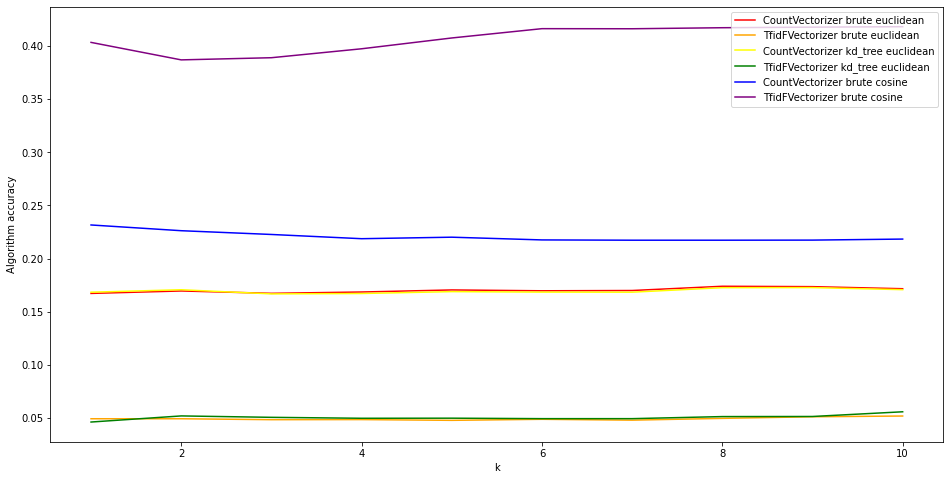

In [26]:
scale = np.arange(1, 11)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
ax.set_xlabel('k')
ax.set_ylabel('Algorithm accuracy')
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
i = 0
for metric_ in plot_points:
    for algorithm_ in plot_points[metric_]:
        for vectorizer_ in plot_points[metric_][algorithm_]:
            label_ = ' '.join([vectorizer_, algorithm_, metric_])
            ax.plot(scale, plot_points[metric_][algorithm_][vectorizer_],
                    color=colors[i], label=label_)
            i += 1
ax.legend()
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [27]:
print('Best score: {} at k = {}, algorithm = {}, metric = {}, vectorizer = {}'.format(best_score, *best_score_spec))

Best score: 0.4180672597774368 at k = 10, algorithm = brute, metric = cosine, vectorizer = TfidFVectorizer


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [28]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

Причиной разного качества работы на train- и test-части может быть несовпадение словаря слов, содержащихся в этих частях датасета.